In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Probit

In [2]:
fuel= pd.read_csv('master_data/Rifornimenti_Carburante_ClubQ8.csv', sep=';')
fuel.sort_values(by=['COD_PAN_DA_POS'], inplace=True)
fuel['DATA_OPERAZIONE'] = fuel['DATA_OPERAZIONE'].astype('datetime64')
#fuel['DATA_OPERAZIONE'] = fuel['DATA_OPERAZIONE'].dt.date
fuel['DATA_OPERAZIONE'] = fuel['DATA_OPERAZIONE'].dt.to_period('M')
#fuel.set_index(['DATA_OPERAZIONE','COD_PAN_DA_POS'], drop=True, append=False, inplace=False, verify_integrity=False)
fuel.head(10)

,COD_PAN_DA_POS,COD_PV,DATA_OPERAZIONE,PRODOTTO,MODALITA_VENDITA,LITRI,PUNTI_CARBURANTE
8029641,7071161603000001164,1818,2021-07,CARICO BENZINA,SELF,50,50
10916133,7071161603000001164,1818,2021-08,CARICO BENZINA,SELF,46,46
5336444,7071161603000001198,1810,2021-05,CARICO GASOLIO,SERVITO,57,57
6559225,7071161603000001198,1810,2021-06,CARICO GASOLIO,SERVITO,54,54
8245667,7071161603000001198,1810,2021-07,CARICO GASOLIO,SERVITO,56,56
8990872,7071161603000001198,1810,2021-07,CARICO GASOLIO,SERVITO,57,57
1268704,7071161603000001198,1810,2021-03,CARICO GASOLIO,SERVITO,54,54
857735,7071161603000001198,1810,2021-03,CARICO GASOLIO,SERVITO,48,48
10798037,7071161603000001255,688,2021-08,CARICO BENZINA,SERVITO,12,12
11920,7071161603000001305,1818,2021-03,CARICO BENZINA,SELF,25,25


In [3]:
#fuel.set_index(['DATA_OPERAZIONE','COD_PAN_DA_POS'], inplace = True)
#fuel.index

In [4]:
#Accumulated points by customer 
fuel['Accumulated Points']= fuel.groupby(['COD_PAN_DA_POS'])['PUNTI_CARBURANTE'].cumsum(axis = 0) 
fuel.head(30)

,COD_PAN_DA_POS,COD_PV,DATA_OPERAZIONE,PRODOTTO,MODALITA_VENDITA,LITRI,PUNTI_CARBURANTE,Accumulated Points
8029641,7071161603000001164,1818,2021-07,CARICO BENZINA,SELF,50,50,50
10916133,7071161603000001164,1818,2021-08,CARICO BENZINA,SELF,46,46,96
5336444,7071161603000001198,1810,2021-05,CARICO GASOLIO,SERVITO,57,57,57
6559225,7071161603000001198,1810,2021-06,CARICO GASOLIO,SERVITO,54,54,111
8245667,7071161603000001198,1810,2021-07,CARICO GASOLIO,SERVITO,56,56,167
8990872,7071161603000001198,1810,2021-07,CARICO GASOLIO,SERVITO,57,57,224
1268704,7071161603000001198,1810,2021-03,CARICO GASOLIO,SERVITO,54,54,278
857735,7071161603000001198,1810,2021-03,CARICO GASOLIO,SERVITO,48,48,326
10798037,7071161603000001255,688,2021-08,CARICO BENZINA,SERVITO,12,12,12
11920,7071161603000001305,1818,2021-03,CARICO BENZINA,SELF,25,25,25


In [5]:
mfuel = fuel.groupby(['COD_PAN_DA_POS', 'DATA_OPERAZIONE'])['PUNTI_CARBURANTE'].sum()
mfuel.head(30)

COD_PAN_DA_POS       DATA_OPERAZIONE
7071161603000001164  2021-07             50
                     2021-08             46
7071161603000001198  2021-03            102
                     2021-05             57
                     2021-06             54
                     2021-07            113
7071161603000001255  2021-08             12
7071161603000001305  2021-03             55
                     2021-04            150
                     2021-05             75
                     2021-06             79
                     2021-07             95
                     2021-08             55
7071161603000001313  2021-03             31
                     2021-04             60
                     2021-05             30
                     2021-06             87
                     2021-07             68
                     2021-08             32
7071161603000001370  2021-04             27
                     2021-05            114
                     2021-06           

In [6]:
premi = pd.read_csv('master_data/Premi_ClubQ8.csv', sep=';', decimal = ',')
premi.sort_values(by=['COD_PAN_DA_POS'], inplace=True)
#premi['PUNTI_RICHIESTI'].astype('float64')
premi['DATA_OPERAZIONE'] = premi['DATA_OPERAZIONE'].astype('datetime64')
premi['DATA_OPERAZIONE'] = premi['DATA_OPERAZIONE'].dt.to_period('M')
premi.head(10)

acc_points = premi.merge(mfuel, how='inner', on='COD_PAN_DA_POS')
df_points = acc_points.iloc[:,[0,1,8]]

df_points['Points'] = df_points['COD_PAN_DA_POS'] + df_points['DATA_OPERAZIONE']
df_points['Points'] = df_points.groupby(['COD_PAN_DA_POS', 'DATA_OPERAZIONE'])['PUNTI_CARBURANTE'].transform('sum')
#see : https://stackoverflow.com/questions/34099684/how-to-use-groupby-transform-across-multiple-columns

df_points = df_points.drop('PUNTI_CARBURANTE', 1)


df_points = df_points.rename(columns={'COD_PAN_DA_POS': 'CustNumber', 'DATA_OPERAZIONE': 'Date'})

df_points['Points2'] = (df_points['Points']**2)

df_points.drop_duplicates(subset=['Date', 'CustNumber'], keep='first', inplace=True)
df_points = df_points.sort_values(by=['CustNumber', 'Date'], ascending = [True, True])

df_points['PointsSpent'] = (df_points['Points'] - df_points['Points'].shift()).fillna(0)

#Check all the rows with a duplicated customer number 
#It shows that there is an evolution of the number of points and thus good for the probit/logit
regular_cust = df_points[df_points['CustNumber'].duplicated() == True]
print(len(regular_cust))
regular_cust.head(100)

/var/folders/c5/6ls10kd543qg372hhy_r3nc00000gn/T/ipykernel_14996/1403555182.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_points['Points'] = df_points['COD_PAN_DA_POS'] + df_points['DATA_OPERAZIONE']
/var/folders/c5/6ls10kd543qg372hhy_r3nc00000gn/T/ipykernel_14996/1403555182.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_points['Points'] = df_points.groupby(['COD_PAN_DA_POS', 'DATA_OPERAZIONE'])['PUNTI_CARBURANTE'].transform('sum')
/var/folders/c5/6ls10kd543qg372hhy_r3nc00000gn/T/ipykerne

127987


,CustNumber,Date,Points,Points2,PointsSpent
103,7071161603000008433,2020-11,3704,13719616,2778.0
109,7071161603000008433,2021-02,1852,3429904,-1852.0
91,7071161603000008433,2021-03,1852,3429904,0.0
151,7071161603000010041,2021-07,567,321489,0.0
206,7071161603000010512,2020-11,669,447561,-669.0
...,...,...,...,...,...
2614,7071161603000036038,2020-11,264,69696,0.0
2610,7071161603000036038,2021-01,264,69696,0.0
2640,7071161603000036137,2020-12,932,868624,-466.0
2650,7071161603000036137,2021-04,466,217156,-466.0


In [7]:
#Creating the target variable by taking the assumption that an increase of points from one month to the next one
# (from t-1 to t) means increasing fuel purchase
df_points['IncreaseFuel'] = np.where(df_points['PointsSpent'] < 0, 0, 1)

#Logistic regression using SkLearn

features_cols = ['Points', 'Points2', 'PointsSpent']
X = df_points[features_cols]

y = df_points['IncreaseFuel']

print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
logit = LogisticRegression()
logit.fit(X_train, y_train)
y_pred = logit.predict(X_test)


#Checking the validity of the model
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

(341487, 3) (341487,)


array([[23565,  2458],
       [    3, 42272]])

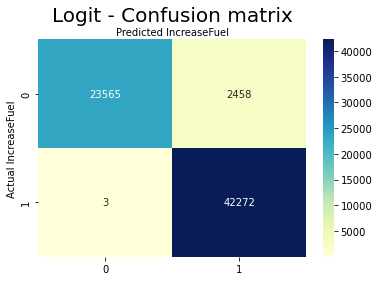

Accuracy : 96.39667340185657%
Precision: 94.50480661748267%
Recall: 99.99290360733293%


In [15]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.title('Logit - Confusion matrix', fontsize=20)
plt.ylabel('Actual IncreaseFuel')
plt.xlabel('Predicted IncreaseFuel')
#plt.tight_layout()
plt.savefig('figures/cnf_matrix_logit.png')
plt.show()

#Metrics

accuracy, precision, recall = metrics.accuracy_score(y_test, y_pred), metrics.precision_score(y_test, y_pred), metrics.recall_score(y_test, y_pred)
print('Accuracy : {}%'.format(accuracy*100))
print('Precision: {}%'.format(precision*100))
print('Recall: {}%'.format(recall*100))

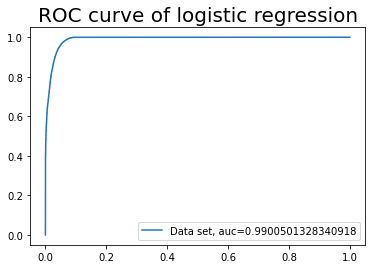

In [16]:
#Receiver Operating Characteristic (ROC) curve

y_pred_proba = logit.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="Data set, auc="+str(auc))
plt.title('ROC curve of logistic regression', fontsize=20)
plt.legend()
plt.savefig('figures/roc_logit.png')
plt.show()

#Source : https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python

/Users/tomrigal/opt/miniconda3/envs/gbac/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


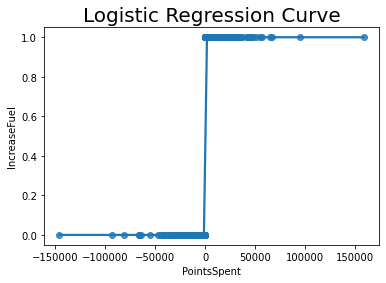

In [17]:
sns.regplot(x='PointsSpent', y='IncreaseFuel', data=df_points, logistic=True, ci=None)
plt.title('Logistic Regression Curve', fontsize=20)
plt.savefig('figures/regplot_logit.png')
plt.show()

In [11]:
#Probit regression using StatsModels

#Add a constant in the model (absent by default with SM package)
print(X,y)
#X = sm.add_constant(X)
#probit = Probit(y, X.astype(float))
#probit_model = probit.fit()
model1 = sm.Probit(y,sm.add_constant(X)).fit()
model1.summary()

#model2 = sm.Probit.from_formula('IncreaseFuel ~ Points + Points2 + PointsSpent',data=df_points).fit()
#model2.summary()

         Points   Points2  PointsSpent
0           616    379456          0.0
12          297     88209       -319.0
17         2518   6340324       2221.0
29          357    127449      -2161.0
33          104     10816       -253.0
...         ...       ...          ...
2444799     385    148225        106.0
2444804     333    110889        -52.0
2444809     666    443556        333.0
2444819     295     87025       -371.0
2444824    3290  10824100       2995.0

[341487 rows x 3 columns] 0          1
12         0
17         1
29         0
33         0
          ..
2444799    1
2444804    0
2444809    1
2444819    0
2444824    1
Name: IncreaseFuel, Length: 341487, dtype: int64
Optimization terminated successfully.
         Current function value: nan
         Iterations 2


/Users/tomrigal/opt/miniconda3/envs/gbac/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:2201: RuntimeWarning: invalid value encountered in true_divide
  L = q*self.pdf(q*XB)/self.cdf(q*XB)


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:           IncreaseFuel   No. Observations:               341487
Model:                         Probit   Df Residuals:                   341483
Method:                           MLE   Df Model:                            3
Date:                Sat, 15 Jan 2022   Pseudo R-squ.:                     nan
Time:                        01:55:51   Log-Likelihood:                    nan
converged:                       True   LL-Null:                   -2.2662e+05
Covariance Type:            nonrobust   LLR p-value:                       nan
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const              nan        nan        nan        nan         nan         nan
Points             nan        nan        nan        nan         nan         nan
Points2            nan        nan        nan        nan         nan         nan
PointsSpent        nan        nan        nan        nan         nan         nan
===============================================================================
"""